# Building Streamlit Dashboard for KNN 

This document serves as a breakdown of streamlit_KNN.py 

In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.feature_selection import f_classif
import itertools
import sys
import importlib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, make_scorer
from joblib import Parallel, delayed, parallel_backend
from threadpoolctl import threadpool_limits
import matplotlib.pylab as plt
import os
from sklearn.inspection import permutation_importance
from scipy.stats import norm, t
from sklearn.base import clone

sys.path.append("../")
from proj_mod import training
importlib.reload(training);

## Preparation 

In [2]:
str_data="../data/raw.csv"
df=pd.read_csv(str_data)
#Set raw features used 
features=["X1","X3","X4","X6"] 
#Set target 
target=["Y"] 

#Set dataframes 
feat=df[features]
tar=df[target]

#Set splits
n_split = 5
n_repeats = 20
RSKF = RepeatedStratifiedKFold(n_splits=n_split, random_state=420, n_repeats=n_repeats)

#Set hyper-parameters 
force=["X1","X6","F_w_mean"] 
nn=5 

#Make pipeline 
pipe=Pipeline([
    ("DataCreate", training.data_creator()),
    ("DataSelector", training.data_selector(force=force)),
    ("scale",StandardScaler()),
    ("KNN",KNeighborsClassifier(n_neighbors=nn))]
)

## Train and save model 

In [3]:
enu_split=enumerate(list(RSKF.split(X=feat, y=tar)))
def train_once(index:int, train_index, pipe: Pipeline): 
    x_tr=feat.iloc[train_index]
    y_tr=tar.iloc[train_index]
    y_tr=np.ravel(y_tr.values)
    
    fitted=clone(pipe)
    fitted.fit(X=x_tr,y=y_tr)
    
    return index, fitted 
    
models=Parallel(n_jobs=-1,backend="loky",verbose=10)(
    delayed(train_once)(
        index=index, 
        train_index=train_index,
        pipe=pipe
    )
    for index, (train_index, _) in enu_split
)

model_dict=dict(models)

model_dict

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  80 out of 100 | elapsed:    3.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed:    3.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished


{0: Pipeline(steps=[('DataCreate', data_creator()),
                 ('DataSelector', data_selector(force=['X1', 'X6', 'F_w_mean'])),
                 ('scale', StandardScaler()), ('KNN', KNeighborsClassifier())]),
 1: Pipeline(steps=[('DataCreate', data_creator()),
                 ('DataSelector', data_selector(force=['X1', 'X6', 'F_w_mean'])),
                 ('scale', StandardScaler()), ('KNN', KNeighborsClassifier())]),
 2: Pipeline(steps=[('DataCreate', data_creator()),
                 ('DataSelector', data_selector(force=['X1', 'X6', 'F_w_mean'])),
                 ('scale', StandardScaler()), ('KNN', KNeighborsClassifier())]),
 3: Pipeline(steps=[('DataCreate', data_creator()),
                 ('DataSelector', data_selector(force=['X1', 'X6', 'F_w_mean'])),
                 ('scale', StandardScaler()), ('KNN', KNeighborsClassifier())]),
 4: Pipeline(steps=[('DataCreate', data_creator()),
                 ('DataSelector', data_selector(force=['X1', 'X6', 'F_w_mean'])),
      

# Set changes

In [4]:
x1_delta=1
x3_delta=0
x4_delta=0
x6_delta=0

dict_deltas={
    "X1": x1_delta, 
    "X3": x3_delta, 
    "X4": x4_delta, 
    "X6": x6_delta
}

## Evaluate 

In [5]:
enu_split=enumerate(list(RSKF.split(X=feat, y=tar)))
def eva_once(index: int, test_index, in_dict_deltas: dict): 
    #Take in test features and create altered data
    x_te_o=feat.iloc[test_index].copy(deep=True)    
    x_te_i=x_te_o.copy(deep=True)
    arr_o=np.array([x_te_i[feature] for feature in features]).transpose()
    arr_delt=np.array([in_dict_deltas[feature] for feature in features])
    arr_i=arr_o+arr_delt
    arr_i=arr_i.clip(min=np.full(shape=4,fill_value=0),max=np.full(shape=4,fill_value=5))
    x_te_i=pd.DataFrame(dict(zip(x_te_i.columns, arr_i.transpose())))
    
    #Load in the right model 
    cur_pipe=model_dict[index]
    
    #Make predictions and produce expected improvement pct 
    pos_o=cur_pipe.predict(X=x_te_o).mean() 
    pos_i=cur_pipe.predict(X=x_te_i).mean()
    
    #Load in target values
    y_te_o=tar.iloc[test_index]
    y_te_o=np.ravel(y_te_o.values)
    pos_acc=y_te_o.mean()
    
    return (pos_i-pos_o)/pos_o, (pos_i-pos_acc)/pos_acc

results = Parallel(n_jobs=-1, backend="loky", verbose=10)(
    delayed(eva_once)(
        index=index, 
        test_index=test_index,
        in_dict_deltas=dict_deltas
    )
    for index, (_, test_index) in enu_split 
)

imp_pct=np.array(results)

imp_pct    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08627843856811523s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  80 out of 100 | elapsed:    2.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished


array([[0.42857143, 0.42857143],
       [0.13333333, 0.30769231],
       [0.46666667, 0.57142857],
       [0.72727273, 0.35714286],
       [0.        , 0.21428571],
       [0.61538462, 0.5       ],
       [0.05882353, 0.38461538],
       [0.46153846, 0.35714286],
       [0.21428571, 0.21428571],
       [0.33333333, 0.42857143],
       [0.28571429, 0.28571429],
       [0.25      , 0.53846154],
       [0.5       , 0.07142857],
       [0.5       , 0.5       ],
       [0.17647059, 0.42857143],
       [0.66666667, 0.42857143],
       [0.26666667, 0.46153846],
       [0.25      , 0.42857143],
       [0.38461538, 0.28571429],
       [0.375     , 0.57142857],
       [0.77777778, 0.14285714],
       [0.3125    , 0.61538462],
       [0.5       , 0.28571429],
       [0.36363636, 0.07142857],
       [0.1875    , 0.35714286],
       [0.35294118, 0.64285714],
       [0.42857143, 0.53846154],
       [0.33333333, 0.14285714],
       [0.26666667, 0.35714286],
       [0.5       , 0.07142857],
       [0.

## Make record and graph

In [45]:
df_whatif=pd.DataFrame(dict(zip(["rel pred", "rel truth"],imp_pct.transpose())))
df_whatif

,rel pred,rel truth
0,0.428571,0.428571
1,0.133333,0.307692
2,0.466667,0.571429
3,0.727273,0.357143
4,0.000000,0.214286
...,...,...
95,0.285714,0.285714
96,0.066667,0.230769
97,0.500000,0.285714
98,0.210526,0.642857


In [49]:
df_whatif.agg({"rel pred": ["mean", "std"], "rel truth": ["mean", "std"]})

,rel pred,rel truth
mean,0.346254,0.373022
std,0.180072,0.163671


Text(0.5, 1.0, 'Improvement relative to recorded happiness rate')

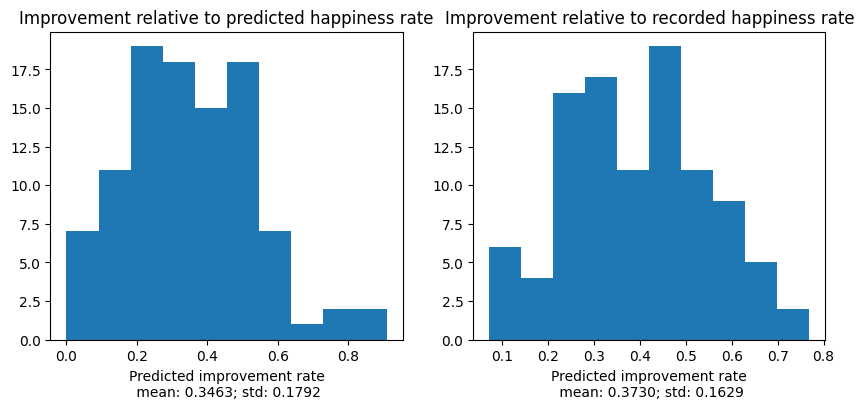

In [59]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
#Relative to predicted happiness rate 
rp_mean=df_whatif["rel pred"].to_numpy().mean()
rp_std=df_whatif["rel pred"].to_numpy().std()
axs[0].hist(df_whatif["rel pred"])
axs[0].set_xlabel("Predicted improvement rate"+f"\n mean: {rp_mean:,.4f}; std: {rp_std:,.4f}")
axs[0].set_title("Improvement relative to predicted happiness rate")

#Relative to recored happiness rate
th_mean=df_whatif["rel truth"].to_numpy().mean()
th_std=df_whatif["rel truth"].to_numpy().std()
axs[1].hist(df_whatif["rel truth"])
axs[1].set_xlabel("Predicted improvement rate"+f"\n mean: {th_mean:,.4f}; std: {th_std:,.4f}")
axs[1].set_title("Improvement relative to recorded happiness rate")


Run this file to generate the streamlit dashboard for the best KNN model. 

## Suggest Business Goal 

In [6]:
def comp_k(sum:int, k: int=len(features)): 
    for tot in range(1,sum+1):
        for cuts in itertools.combinations(range(tot+k-1), k-1): 
            prev=-1 #First "cut"
            parts=[]
            #Each part should be current cut - previous cut -1 
            for cut in cuts + (tot+k-1,): #Last "cut" is always the very last entry 
                parts.append(cut-prev-1)
                prev=cut 
            yield np.array(parts)

imp_bgt=2
lnr_combs=np.array(list(comp_k(sum=imp_bgt)))
lnr_combs
# for lnr_comb in lnr_combs:
#     print(lnr_comb)

array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 2],
       [0, 0, 1, 1],
       [0, 0, 2, 0],
       [0, 1, 0, 1],
       [0, 1, 1, 0],
       [0, 2, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 1, 0, 0],
       [2, 0, 0, 0]])

In [87]:

df_bgt_results=pd.DataFrame(dict(zip(features, [[] for _ in features ])))
df_bgt_results["mean_rel_pred"], df_bgt_results["std_rel_pred"], df_bgt_results["mean_rel_act"], df_bgt_results["std_rel_act"]=[],[],[],[]
df_bgt_results

,X1,X3,X4,X6,mean_rel_pred,std_rel_pred,mean_rel_act,std_rel_act


In [88]:
imp_bgt=1
for lnr_comb in comp_k(sum=imp_bgt): 
    cur_dict_delta=dict(zip(features, lnr_comb))
    enu_split=enumerate(list(RSKF.split(X=feat, y=tar)))
    # print(cur_dict_delta)
    results = Parallel(n_jobs=-1, backend="loky", verbose=10)(
        delayed(eva_once)(
            index=index, 
            test_index=test_index,
            in_dict_deltas=cur_dict_delta
        )
        for index, (_, test_index) in enu_split 
    )
    imp_pct=np.array(results).transpose()
    # print(imp_pct)
    df_cur_results=pd.DataFrame(dict(zip(features, lnr_comb.reshape(-1,1))))
    df_cur_results["mean_rel_pred"], df_cur_results["std_rel_pred"]=imp_pct[0].mean(), imp_pct[0].std()
    df_cur_results["mean_rel_act"], df_cur_results["std_rel_act"]=imp_pct[1].mean(), imp_pct[1].std()
    df_bgt_results=pd.concat([df_bgt_results,df_cur_results])
    
df_bgt_results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08185124397277832s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  80 out of 100 | elapsed:    2.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08456707000732422s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elap

,X1,X3,X4,X6,mean_rel_pred,std_rel_pred,mean_rel_act,std_rel_act
0,0.0,0.0,0.0,1.0,-0.131264,0.158910,-0.107582,0.190852
0,0.0,0.0,1.0,0.0,0.103507,0.132844,0.136209,0.191168
0,0.0,1.0,0.0,0.0,0.029963,0.178765,0.053407,0.186375
0,1.0,0.0,0.0,0.0,0.346254,0.179169,0.373022,0.162850


In [94]:
order_by="mean_rel_act"
df_show=df_bgt_results.sort_values(by=[order_by],ascending=False)
df_best=df_show.iloc[[0]]
df_best

,X1,X3,X4,X6,mean_rel_pred,std_rel_pred,mean_rel_act,std_rel_act
0,1.0,0.0,0.0,0.0,0.346254,0.179169,0.373022,0.16285


In [99]:
df_best.loc[0,"X1"]

np.float64(1.0)